## Comparativa de resultados

En este notebook vamos a extraer la comparativa entre cúmulos, analizando los strong candidates a albergar IMBH.

In [1]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astroquery.vizier import Vizier
from dotenv import load_dotenv
from google.cloud import storage

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)
            

from hyper_velocity_stars_detection.jobs.utils import read_catalog_file
from hyper_velocity_stars_detection.jobs.google_jobs.utils import load_project
from hyper_velocity_stars_detection.cluster_detection.cluster_detection import get_distance_from_references
from hyper_velocity_stars_detection.cluster_detection.search_clustering_method import (
    ParamsDistribution,
    ParamsOptimizator,
)
from hyper_velocity_stars_detection.sources.utils import get_main_id


load_dotenv("../data/.env")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../data/hvs-storage.json"
PATH = "../data/globular_clusters"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Strong Candidates

In [2]:
data_clusters = pd.read_csv("../data/clean_results_dr3.csv", index_col=0)
data_clusters.head()

,Name,N_count,parallax,e_parallax,pmRA_,e_pmRA_,pmDE,e_pmDE,RV,e_RV,...,e__M_L_6,Ltot,e_Ltot,E_Ltot,Mtot,e_Mtot,E_Mtot,M_L,e_M_L,E_M_L
0,ngc 104,11166,0.226134,0.067449,5.243541,0.331773,-2.581109,0.350568,-17.572102,10.016526,...,0.224,5.68,0.01,0.01,6.05,0.04,0.04,2.348,0.239,0.239
1,ngc 288,1190,0.183061,0.116156,4.171194,0.178887,-5.697644,0.191601,NaN,NaN,...,0.186,4.56,0.01,0.01,4.85,0.04,0.04,1.972,0.165,0.165
2,ngc 362,2206,0.184869,0.122491,6.696697,0.245211,-2.571089,0.213431,NaN,NaN,...,0.190,5.23,0.01,0.01,5.53,0.04,0.04,2.013,0.171,0.171
3,ngc 1261,624,0.133308,0.096178,1.607733,0.254646,-2.090835,0.277623,71.965806,4.695595,...,0.180,4.94,0.00,0.00,5.20,0.04,0.04,1.928,0.158,0.158
6,ngc 1851,1477,0.157495,0.113801,2.134306,0.203496,-0.655837,0.246089,NaN,NaN,...,0.187,5.20,0.00,0.00,5.49,0.04,0.04,1.981,0.166,0.166


In [3]:
s_candidates_list = ["ngc 104", "ngc 5139", "ngc 5286", "ngc 6266", "ngc 6388"]
data_sc = data_clusters[data_clusters.Name.isin(s_candidates_list)]


s_candidates = {}
for sc in s_candidates_list:
    s_candidates[sc] = load_project(cluster_name=sc, project_id = os.getenv("PROJECT_ID"), bucket_name=os.getenv("BUCKET"),path=PATH)
    print("Descarga completada de %s" % sc)

Descarga completada de ngc 104
Descarga completada de ngc 5139
Descarga completada de ngc 5286
Descarga completada de ngc 6266
Descarga completada de ngc 6388


In [4]:
cols = ["Name","N_count", "parallax", "pmRA_", "pmDE", "M_L", "Mtot", "Ltot", "HVS_count", "HVS_pmRA_", "HVS_pmDE", "HVS_Distance", "HVS_cosTheta", "XS_count", "XS_Distance"]

data_sc[cols]

,Name,N_count,parallax,pmRA_,pmDE,M_L,Mtot,Ltot,HVS_count,HVS_pmRA_,HVS_pmDE,HVS_Distance,HVS_cosTheta,XS_count,XS_Distance
0,ngc 104,11166,0.226134,5.243541,-2.581109,2.348,6.05,5.68,26,17.156729,4.082295,6.763383,0.754122,36,0.002477
21,ngc 5139,6589,0.195890,-3.247342,-6.746219,1.872,6.37,6.10,0,NaN,NaN,NaN,NaN,9,0.025205
23,ngc 5286,560,0.124641,0.200930,-0.150276,1.868,5.65,5.38,2,7.359346,2.042244,0.343691,0.605578,2,0.001583
49,ngc 6266,369,0.183322,-4.931936,-2.967303,1.950,5.86,5.57,0,NaN,NaN,NaN,NaN,2,0.000797
66,ngc 6388,920,0.133347,-1.324383,-2.711157,2.552,6.02,5.62,0,NaN,NaN,NaN,NaN,3,0.005878


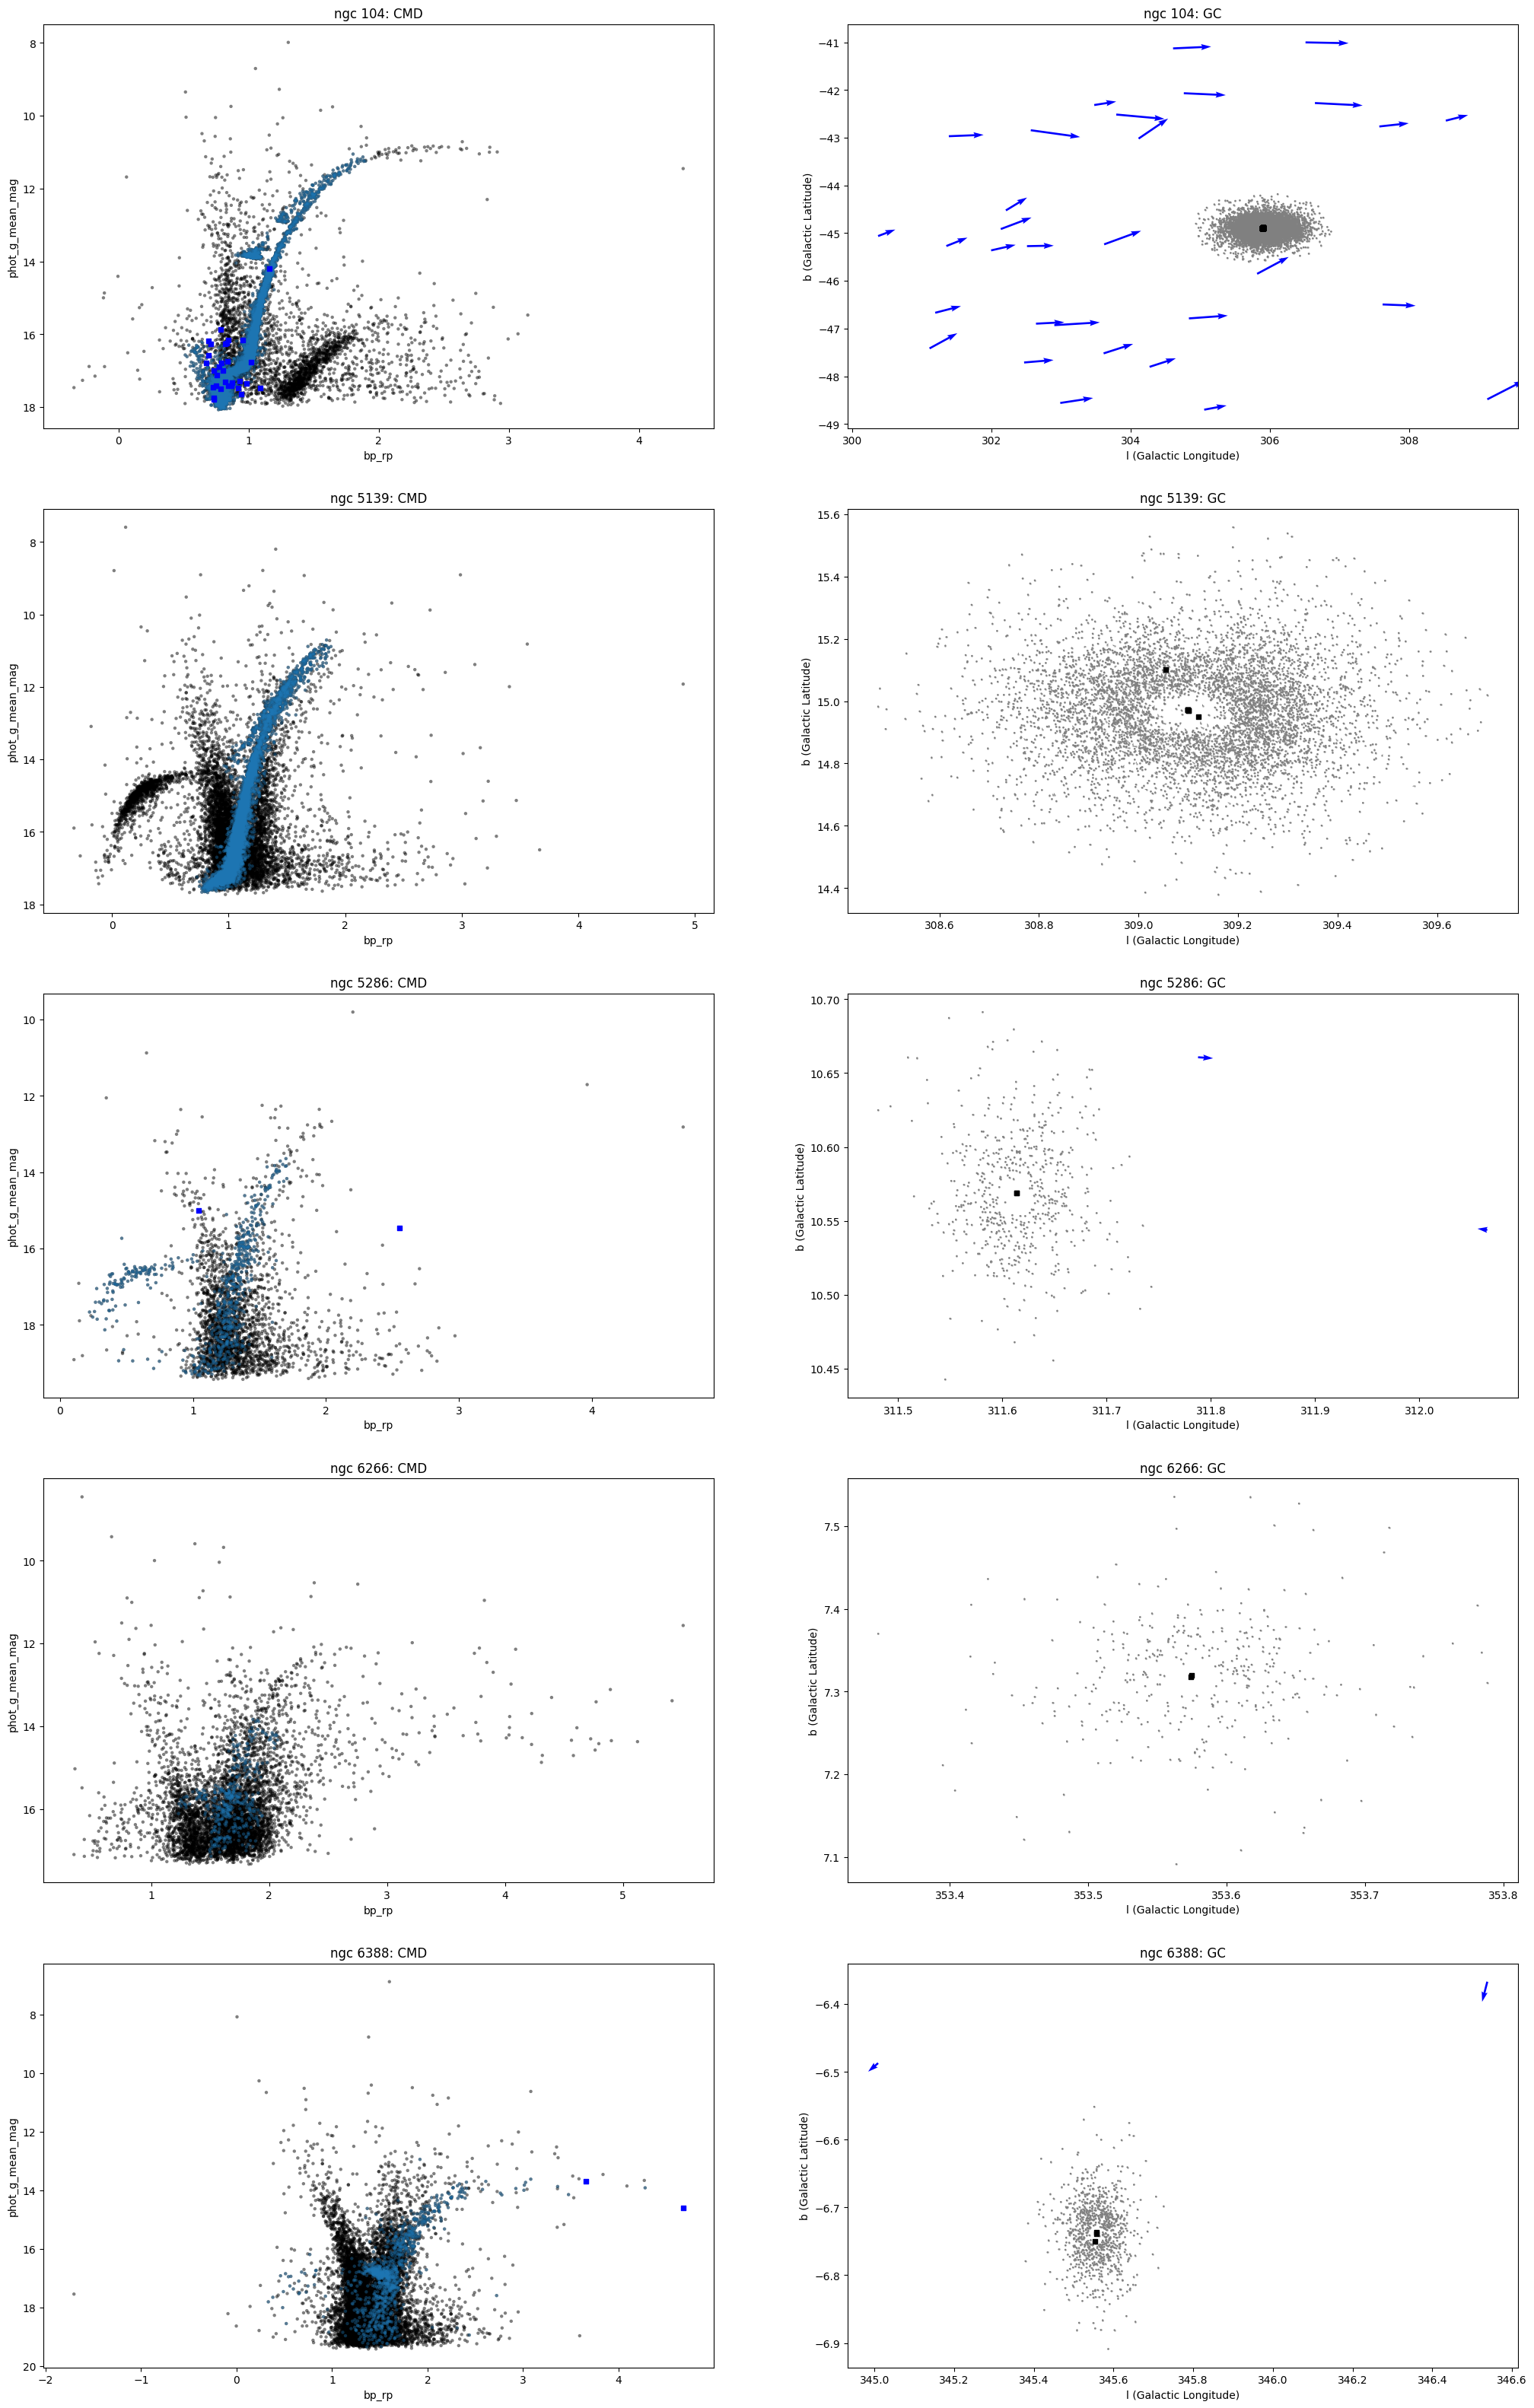

In [12]:
n_clusters = len(s_candidates_list)
fig_general, axs = plt.subplots(n_clusters, 2, figsize=(25, 8 * n_clusters))

for i, sc in enumerate(s_candidates_list):
    project = s_candidates[sc]
    _, _ = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False,
            clusters=project.clustering_results.main_label,
            ax = axs[i, 0],
            random_state=123,
            filter_selected_cmd=False
    )
    axs[i,0].set_title("%s: CMD" % sc)
    _, _ = project.plot_cluster(random_state=123, hvs_candidates_name="df_6_c1", factor_sigma=1, hvs_pm=150,
                                legend=False, factor_size=50, ax=axs[i, 1])
    axs[i,1].set_title("%s: GC" % sc)

fig_general.savefig("ejem.png")

In [72]:
project = s_candidates["ngc 104"]

clustering = project.clustering_results

In [108]:
df_hvs_candidates = project.get_data("df_6_c1")

selected = clustering.selected_hvs(
    df_hvs_candidates, 1.0, 150, random_state = 123)
cluster = project.clustering_results.remove_outliers_gc(123)

columns_cmd = ["phot_g_mean_flux", "bp_rp"]
cluster_cmd = cluster[columns_cmd]

distances = np.zeros(selected.shape[0])
positions = []
k=0
for pos, star in selected.iterrows():
    cmd_point = star[columns_cmd]
    distances[k] = np.min(((cmd_point.values - cluster_cmd.values)**2).sum(axis=1)**(1/2))
    positions.append(pos)
    k+=1
    
distances

array([ 0.08183399,  0.10381698, 16.29461629,  0.33587143,  0.09312336,
        0.39658547,  0.12202903,  0.04025984,  0.12704867,  0.07316321,
        0.1228677 ,  0.20579481,  0.97237393,  0.52547186,  0.36812252,
        6.74584532,  2.30499431,  0.41076988,  0.2460073 ,  0.33362975,
        4.43849784,  1.05713675,  5.03840253,  1.94240126,  0.13583781,
        0.16085261,  0.05495666,  0.21007462,  0.19198723,  1.22231893,
        1.17896694])

In [109]:
positions

[48,
 260,
 316,
 391,
 449,
 473,
 589,
 605,
 663,
 697,
 727,
 759,
 824,
 851,
 884,
 896,
 1004,
 1180,
 1185,
 1266,
 1327,
 1333,
 1373,
 1405,
 1423,
 1476,
 1580,
 1625,
 1637,
 1793,
 1797]

In [95]:
-115.2325838 ** 2, 0.086179730000000**2

(-13278.548369224023, 0.007426945862872899)